In [1]:
#import necessary libraries

from PIL import Image
from PIL.ExifTags import TAGS, GPSTAGS
import os

from PIL import Image
from io import BytesIO

import matplotlib.pyplot as plt
from IPython.display import display

import plotly.graph_objects as go
import plotly.io as pio

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from scipy.signal import correlate2d
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array

from scipy.signal import find_peaks
import math

from urllib import request
from PIL import Image
import os
from math import *
from tqdm import tqdm


In [2]:
#replace with path to the project folder
current_dir = 'e:\\BOSTON UNIVERSITY\\CAS CS 549\\ml-terc-image-geolocation'  
os.chdir(current_dir)

In [28]:
def get_exif_data(image_path):
    """
    Function to extract specific EXIF metadata - GPS coordinates, 
    camera model, and focal length from an image file. 
    --------------------------------------------------------------
    Parameters:
    image_path: A string representing the file path of the image from which the EXIF data is to be extracted.
    --------------------------------------------------------------
    Returns:
    A tuple of lists containing the EXIF tags and their corresponding values.
    """
    desired_tags = ['GPSLatitudeRef', 'GPSLatitude', 'GPSLongitudeRef', 'GPSLongitude', 'GPSAltitude', 'Model', 'FocalLength', "DateTime"]

    image = Image.open(image_path)
    exif_data = image._getexif()
    exif_dict = {}

    if exif_data is not None:
        for key, value in exif_data.items():
            if key in TAGS:
                tag = TAGS[key]

                if tag == 'GPSInfo':
                    gps_data = {}
                    for t in value:
                        sub_tag = GPSTAGS.get(t, t)
                        if sub_tag in desired_tags:
                            gps_data[sub_tag] = value[t]
                    exif_dict.update(gps_data)
                elif tag in desired_tags:
                    exif_dict[tag] = value

    return exif_dict


def get_geo_coord(lat, ref_lat, lon, ref_lon):
    """
    Function to convert EXIF GPS coordinates to decimal format.
    --------------------------------------------------------------
    Parameters:
    lat: A list of tuples containing the GPS latitude coordinates in degrees, minutes, and seconds.
    ref_lat: A string representing the reference direction(N, S) of the GPS latitude coordinates.
    lon: A list of tuples containing the GPS longitude coordinates in degrees, minutes, and seconds.
    ref_lon: A string representing the reference direction(E, W) of the GPS longitude coordinates.
    --------------------------------------------------------------
    Returns:
    A tuple of floats representing the GPS coordinates in decimal format.
    """
    deg, minutes, seconds = lat
    decimal_deg_lat = deg + (minutes / 60.0) + (seconds / 3600.0)

    # Adjusting for the reference direction
    if ref_lat == 'S':
        decimal_deg_lat *= -1

    deg, minutes, seconds = lon
    decimal_deg_lon = deg + (minutes / 60.0) + (seconds / 3600.0)

    # Adjusting for the reference direction
    if ref_lon == 'W':
        decimal_deg_lon *= -1

    return decimal_deg_lat, decimal_deg_lon


def fetch_map_image(lat, lon, zoom, size, mapbox_access_token):
    """
    Function to fetch a static map image using Plotly.
    --------------------------------------------------------------
    Parameters:
    lat (float): Latitude of the location.
    lon (float): Longitude of the location.
    zoom (int): Zoom level of the image.
    size (str): Size of the image in 'widthxheight' format (e.g., '600x400').
    altitude (float, optional): Altitude of the location. Used for marker representation.
    mapbox_access_token (str): Mapbox access token for rendering the map.
    --------------------------------------------------------------
    Returns:
    A static image (PNG) of the location.
    """
    width, height = map(int, size.split('x'))

    # Create a scatter mapbox plot with Plotly
    fig = go.Figure(go.Scattermapbox(
        lat=[lat],
        lon=[lon],
    ))

    # Set the layout of the map
    fig.update_layout(
        mapbox=dict(
            accesstoken=mapbox_access_token,
            center=go.layout.mapbox.Center(lat=lat, lon=lon),
            zoom=zoom,
            style='satellite'
        ),
        width=width,
        height=height,
        margin=dict(l=0, r=0, t=0, b=0),
    )

    # Generate the figure as a PNG byte array
    image_data = pio.to_image(fig, format='png')

    pil_image = Image.open(BytesIO(image_data))

    return pil_image

def extract_features(img, model):
    """
    Function to preprocess the image and extract features
    --------------------------------------------------------------
    Parameters:
    img: A PIL image object.
    model: A Keras model object.
    --------------------------------------------------------------
    Returns:
    A 4D NumPy array containing the extracted features.
    """
    img_array = img_to_array(img.resize((512, 512)))
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    features = model.predict(img_array)
    return features


def find_query_in_aoi(query_features, aoi_features):
    """
    Author: ChatGPT-4
    Function to find the location of the query image in the AOI image
    --------------------------------------------------------------
    Parameters:
    query_features: A 4D NumPy array containing the features of the query image.
    aoi_features: A 4D NumPy array containing the features of the AOI image.
    --------------------------------------------------------------
    Returns:
    A tuple containing the x and y coordinates of the query image in the AOI image.
    """
    # Perform cross-correlation between the features of the query image and the AOI image
    correlation_map = correlate2d(aoi_features[0, :, :, 0], query_features[0, :, :, 0], boundary='wrap', mode='same')
    
    # Find the location with the highest correlation
    y, x = np.unravel_index(np.argmax(correlation_map), correlation_map.shape)
    
    return (x, y), correlation_map[y, x], correlation_map


def mercator_projection(lat):
    """
    Author: ChatGPT-4
    This function converts latitude to Mercator projection.
    --------------------------------------------------------------
    Parameters:
    lat (float): Latitude in degrees.
    --------------------------------------------------------------
    Returns:
    float: Latitude in Mercator projection.
    """
    return math.log(math.tan(math.radians(lat) / 2 + math.pi / 4))

# def calculate_mapbox_bounding_box(lat_center, lon_center, zoom, image_width, image_height):
#     """
#     Author: ChatGPT-4
#     This function calculates the bounding box of a Mapbox map.
#     --------------------------------------------------------------
#     Parameters:
#     lat_center (float): Latitude of the center of the map.
#     lon_center (float): Longitude of the center of the map.
#     zoom (int): Zoom level of the map.
#     image_width (int): Width of the image.
#     image_height (int): Height of the image.
#     --------------------------------------------------------------
#     Returns:
#     tuple: A tuple containing the coordinates of the top-left, top-right, bottom-right, and bottom-left corners of the image.
#     """
#     # Tile size (in pixels) used by Mapbox
#     tile_size = 512

#     # Number of tiles at the given zoom level
#     num_tiles = 2 ** zoom

#     # Scale factor at this zoom level
#     scale = num_tiles * tile_size

#     # Latitude in Mercator projection
#     mercator_lat = mercator_projection(lat_center)

#     # Convert center longitude and latitude to pixel values
#     pixel_x_center = (lon_center + 180) / 360 * scale
#     pixel_y_center = (1 - mercator_lat / math.pi) / 2 * scale

#     # Calculate pixel coordinates of the corners
#     pixel_x_left = pixel_x_center - image_width / 2
#     pixel_x_right = pixel_x_center + image_width / 2
#     pixel_y_top = pixel_y_center - image_height / 2
#     pixel_y_bottom = pixel_y_center + image_height / 2

#     # Convert pixel coordinates back to lat/lon
#     def pixels_to_latlon(px, py):
#         lon = px / scale * 360 - 180
#         lat = math.degrees(2 * math.atan(math.exp((1 - 2 * py / scale) * math.pi)) - math.pi / 2)
#         return lat, lon

#     top_left = pixels_to_latlon(pixel_x_left, pixel_y_top)
#     top_right = pixels_to_latlon(pixel_x_right, pixel_y_top)
#     bottom_right = pixels_to_latlon(pixel_x_right, pixel_y_bottom)
#     bottom_left = pixels_to_latlon(pixel_x_left, pixel_y_bottom)

#     return top_left, top_right, bottom_right, bottom_left



def calculate_google_maps_bounding_box(lat, lng,  image_size, zoom_level):
    """
    Function to calculate the bounding box of a Google Maps image.
    --------------------------------------------------------------
    Parameters:
    lat_center (float): Latitude of the center of the map.
    lon_center (float): Longitude of the center of the map.
    zoom (int): Zoom level of the map.
    image_width (int): Width of the image.
    image_height (int): Height of the image.
    --------------------------------------------------------------
    Returns:
    tuple: A tuple containing the coordinates of the top-left and bottom-right corners of the image.
    """
    map_pixels = 256 * (2 ** zoom_level)

    # Number of degrees in the entire map
    map_degrees = 360

    # Degrees per pixel
    degrees_per_pixel = map_degrees / map_pixels

    # Calculate the number of pixels for half the image size
    pixel_radius = image_size / 2

    # Calculate the latitude and longitude deltas in degrees
    delta_lat = degrees_per_pixel * pixel_radius / cos(radians(lat))
    delta_lon = degrees_per_pixel * pixel_radius

    top_left = (lat + delta_lat, lng - delta_lon)
    bottom_right = (lat - delta_lat, lng + delta_lon)

    return top_left, bottom_right



def find_best_matches(correlation_map):
    """
    This function finds the best and second-best match in the correlation map.
    --------------------------------------------------------------
    Parameters:
    correlation_map (numpy.ndarray): The correlation map obtained from comparing the query image and the AOI.
    --------------------------------------------------------------
    Returns:
    tuple: A tuple containing the coordinates of the best and second-best matches.
    """
    correlation_map_flat = correlation_map.flatten()
    peaks, _ = find_peaks(correlation_map_flat, height=0)
    sorted_peaks = sorted(peaks, key=lambda x: correlation_map_flat[x], reverse=True)
    best_match_index = sorted_peaks[0]
    second_best_match_index = sorted_peaks[1]
    best_match_coords = np.unravel_index(best_match_index, correlation_map.shape)
    second_best_match_coords = np.unravel_index(second_best_match_index, correlation_map.shape)
    return best_match_coords, second_best_match_coords

def find_midpoint(coord1, coord2):
    """
    This function calculates the midpoint between two coordinates.
    --------------------------------------------------------------
    Parameters:
    coord1 (tuple): The first coordinate (x1, y1).
    coord2 (tuple): The second coordinate (x2, y2).
    --------------------------------------------------------------
    Returns:
    tuple: The midpoint coordinates.
    """
    midpoint = ((coord1[0] + coord2[0]) / 2, (coord1[1] + coord2[1]) / 2)
    return midpoint

def scale_correlation_to_aoi(midpoint, correlation_shape, aoi_size):
    """
    Scale the correlation map coordinates to the AOI image size.
    --------------------------------------------------------------
    Parameters:
    midpoint (tuple): The midpoint coordinates of the correlation map.
    correlation_shape (tuple): The shape of the correlation map.
    aoi_size (tuple): The size of the AOI image.
    --------------------------------------------------------------
    Returns:
    tuple: The scaled coordinates.
    """
    x_scale = aoi_size[0] / correlation_shape[1]
    y_scale = aoi_size[1] / correlation_shape[0]
    
    scaled_x = midpoint[0] * x_scale
    scaled_y = midpoint[1] * y_scale
    
    return scaled_x, scaled_y

def interpolate_geo_coordinates(aoi_midpoint, top_left, bottom_right, aoi_size):
    """
    Author: ChatGPT-4
    Interpolate the AOI image coordinates to geographical coordinates.
    --------------------------------------------------------------
    Parameters:
    aoi_midpoint (tuple): The midpoint coordinates of the AOI image.
    top_left (tuple): The top-left coordinates of the AOI image.
    bottom_right (tuple): The bottom-right coordinates of the AOI image.
    aoi_size (tuple): The size of the AOI image.
    --------------------------------------------------------------
    Returns:
    tuple: The interpolated geographical coordinates.
    """
    lat_range = top_left[0] - bottom_right[0]
    lon_range = bottom_right[1] - top_left[1]
    
    lat_per_pixel = lat_range / aoi_size[1]
    lon_per_pixel = lon_range / aoi_size[0]
    
    lat = top_left[0] - (aoi_midpoint[1] * lat_per_pixel)
    lon = top_left[1] + (aoi_midpoint[0] * lon_per_pixel)
    
    return lat, lon


In [16]:
# Recycled from sliding_window_match_final.ipynb

class GoogleMapDownloader:
    """
        A class which generates high resolution google maps images given
        a gmap API key and location parameters
    """

    def __init__(self, API_key, lat, lng, lgth, img_size=1000):
        """
            GoogleMapDownloader Constructor
            Args:
                API_key:  The GoogleMap API key to load images
                lat:      The latitude of the location required
                lng:      The longitude of the location required
                lgth:     Length of the map in m. The map will be a square.
                          warning: too big length will result in distorded map due to mercator projection.
                img_size: The resolution of the output image as img_size X img_size
                          default to 1000
        """
        lat_rad = (pi/180)*lat
        self._img_size = img_size
        self._lat = lat
        self._lng = lng
        self._zoom = floor(log2(156543.03 * img_size / lgth))
        self._resolution = 156543.03 / (2 ** self._zoom) #(m/px)
        self._nb_tiles = ceil(img_size/500)
        self._tile_lgth = lgth/self._nb_tiles
        self._tile_size = int(self._tile_lgth/self._resolution)
        self._API_key = API_key
        
    def getMercatorFromGPS(self, lng, lat):
        """
        Converts given lat/lon in WGS84 Datum to XY in Spherical Mercator EPSG:900913
        """
        x = 6371000 * lng
        y = 6371000 * log(tan(pi/4 + lat/2))
        return (x, y)

    def getGPSFromMercator(self, x, y):
        """
        Converts XY point from Spherical Mercator EPSG:900913 to lat/lon in WGS84 Datum
        """
        lng = x / 6371000
        lat = 2 * atan(exp(y/6371000)) - pi/2
        return (lng,lat)
    
    def get_zoom_level(self):
        return self._zoom

    def generateImage(self):
        """
            Generates an image by stitching a number of google map tiles together.
            
            Returns:
                A high-resolution Goole Map image.
        """

        lat_rad = (pi/180)*abs(self._lat)
        lng_rad = (pi/180)*abs(self._lng)
        xy_loc  = self.getMercatorFromGPS(lng_rad,lat_rad)

        xy_with_step  = [xy_loc[0]+self._tile_lgth , xy_loc[1]+self._tile_lgth]
        gps_with_step = self.getGPSFromMercator(xy_with_step[0], xy_with_step[1])

        lat_step = (180/pi)*(gps_with_step[1] - lat_rad)
        lon_step = (180/pi)*(gps_with_step[0] - lng_rad)

        border = 20        

        # Determine the size of the image
        width, height = self._tile_size * self._nb_tiles, self._tile_size * self._nb_tiles

        #Create a new image of the size require
        map_img = Image.new('RGB', (width,height))


        nb_tiles_max = self._nb_tiles**2
        counter = 1

        total_tiles = self._nb_tiles ** 2

        with tqdm(total=total_tiles, desc="Downloading Tiles") as pbar:

            for x in range(0, self._nb_tiles):
                for y in range(0, self._nb_tiles) :

                    la = self._lat - y*lat_step + lat_step*(self._nb_tiles-1)/2
                    lo = self._lng + x*lon_step - lon_step*(self._nb_tiles-1)/2

                    url = 'https://maps.googleapis.com/maps/api/staticmap?'
                    url += 'center='+str(la)+','+str(lo)
                    url += '&zoom='+str(self._zoom)
                    url += '&size='+str(self._tile_size+2*border)+'x'+str(self._tile_size+2*border)
                    url += '&maptype=satellite'
                    if self._API_key:url += '&key='+self._API_key
                    # print('getting tile '+str(counter)+"/"+str(nb_tiles_max))
                    counter+=1

                    current_tile = str(x)+'-'+str(y)
                    request.urlretrieve(url, current_tile)
                
                    im = Image.open(current_tile)
                    map_img.paste(im.crop((border,border,self._tile_size+border,self._tile_size+border)), (x*self._tile_size, y*self._tile_size))
                
                    os.remove(current_tile)

                    pbar.update(1)

        print("Resizing map")
        return map_img.resize((self._img_size,self._img_size))


def download_map_image(api_key, lat, lng, map_length, image_size):
    """
    Function to download a high-resolution map image from Google Maps.
    --------------------------------------------------------------
    Parameters:
    api_key: A string representing the Google Maps API key.
    lat: Latitude of the location.
    lng: Longitude of the location.
    map_length: Length of the map in meters.
    image_size: Size of the image in pixels.
    --------------------------------------------------------------
    Returns:
    A PIL image object.
    """
    gmd = GoogleMapDownloader(api_key, lat, lng, map_length, image_size)
    try:
        # Generate the high-resolution map image
        return gmd.generateImage()
    except Exception as e:
        print(f"ERROR: Could not generate the image - {e}")
        return None

# Function to get the zoom level
def get_map_zoom(api_key, lat, lng, map_length, image_size):
    """
    Function to get the zoom level of a map image.
    --------------------------------------------------------------
    Parameters:
    api_key: A string representing the Google Maps API key.
    lat: Latitude of the location.
    lng: Longitude of the location.
    map_length: Length of the map in meters.
    image_size: Size of the image in pixels.
    --------------------------------------------------------------
    Returns:
    An integer representing the zoom level.
    """
    gmd = GoogleMapDownloader(api_key, lat, lng, map_length, image_size)
    return gmd.get_zoom_level()

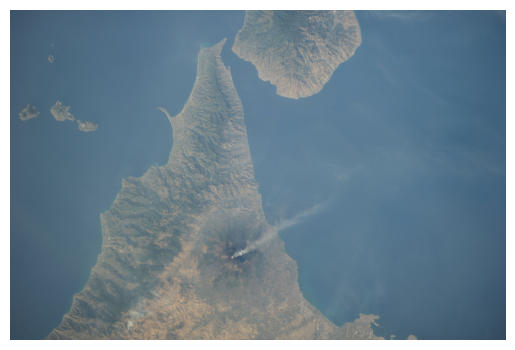

Extracted Metadata:
 {'GPSLatitudeRef': 'N', 'GPSLatitude': (38.0, 42.6228, 0.0), 'GPSLongitudeRef': 'E', 'GPSLongitude': (15.0, 20.829, 0.0), 'GPSAltitude': 414689.1111111111, 'Model': 'NIKON D3S', 'DateTime': '2017:10:16 12:48:31', 'FocalLength': 80.0}


In [17]:
#use exif image to get metadata of interest from the image

# query_img_path = "data\\images\\iss036e049939.jpg" # kilimanjaro
query_img_path = "data\\images\\iss040e092721.jpg" # island img

query_img = Image.open(query_img_path)
plt.imshow(query_img)
plt.axis('off') 
plt.show()

exif_data = get_exif_data(query_img_path)

print(f"Extracted Metadata:\n {exif_data}")

In [18]:
# Extracting GPS data for conversion
gps_latitude = exif_data.get('GPSLatitude', None)
gps_latitude_ref = exif_data.get('GPSLatitudeRef', None)
gps_longitude = exif_data.get('GPSLongitude', None)
gps_longitude_ref = exif_data.get('GPSLongitudeRef', None)

# Check if all GPS data is available
if gps_latitude and gps_latitude_ref and gps_longitude and gps_longitude_ref:
    lat, long = get_geo_coord(gps_latitude, gps_latitude_ref, gps_longitude, gps_longitude_ref)
    print(f"ISS coordinates: {lat}, {long}")
else:
    print("GPS data is incomplete or not available in the image.")

ISS coordinates: 38.71038, 15.34715


In [19]:
# Recycled from sliding_window_match_final.ipynb

# Downloading area of interest image and getting bounding box coordinates
api_key = input('Enter Google Maps API key: ')
map_length = 1200000  # in meters
image_size = 30000  # width and height in pixels
aoi_image_folder = "../data/aoi_images_test/"

query_image_name = os.path.basename(query_img_path).split('.')[0]

# AOI image file path construction
aoi_image_base_name = os.path.splitext(query_image_name)[0] + "_aoi.jpg"
aoi_image_file_path = os.path.join(aoi_image_folder, aoi_image_base_name)

# Instantiate GoogleMapDownloader object
gmd = GoogleMapDownloader(api_key, lat, long, map_length, image_size)

# Check if AOI image already exists
if not os.path.exists(aoi_image_file_path):
    # Download the map image if it doesn't exist
    aoi_img = gmd.generateImage()

    # Save the image if it is not None
    if aoi_img is not None:
        # Ensure the folder exists
        os.makedirs(aoi_image_folder, exist_ok=True)

        # Save the image in JPG format
        aoi_img.save(aoi_image_file_path, "JPEG")
        print(f"AOI image saved at {aoi_image_file_path}")
    else:
        print("No image to save.")
else:
    print(f"AOI image already exists at {aoi_image_file_path}")

# Retrieve the zoom level in both cases (new download or existing file)
zoom_level = gmd.get_zoom_level()
print(f"Zoom level: {zoom_level}")

Image.MAX_IMAGE_PIXELS = None
aoi_img = Image.open(aoi_image_file_path)

AOI image already exists at ../data/aoi_images_test/iss040e092721_aoi.jpg
Zoom level: 11


1/1 [==============================] - 1s 1s/step
Query image found at location: (12, 0) with confidence: 20.614622116088867


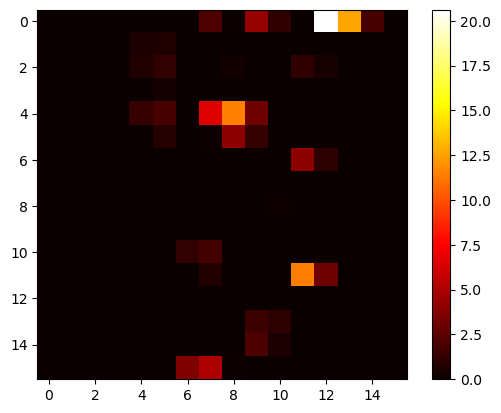

In [20]:
# Load VGG16 model pre-trained on ImageNet data
model = VGG16(weights='imagenet', include_top=False)


# Assuming 'query_img' and 'aoi_img' are your loaded PIL images
query_features = extract_features(query_img, model)
aoi_features = extract_features(aoi_img, model)


# Now, adjust the part where you call the function and plot the results:
location, confidence, correlation_map = find_query_in_aoi(query_features, aoi_features)

# Print the result
print(f"Query image found at location: {location} with confidence: {confidence}")

# Plot the correlation map
plt.imshow(correlation_map, cmap='hot')
plt.colorbar()
plt.show()


Top Left Bounding box coordinates of the AOI image: (51.90973488069034, 5.047467382812499)
Bottom Right Bounding box coordinates of the AOI image: (25.51102511930966, 25.6468326171875)

Midpoint from correlation map: (2.0, 10.0)

Midpoint in AOI image coordinates: (3750.0, 18750.0)

Interpolated geographic coordinates: (35.41054127982741, 7.622388037109374)

Satellite view of the location:


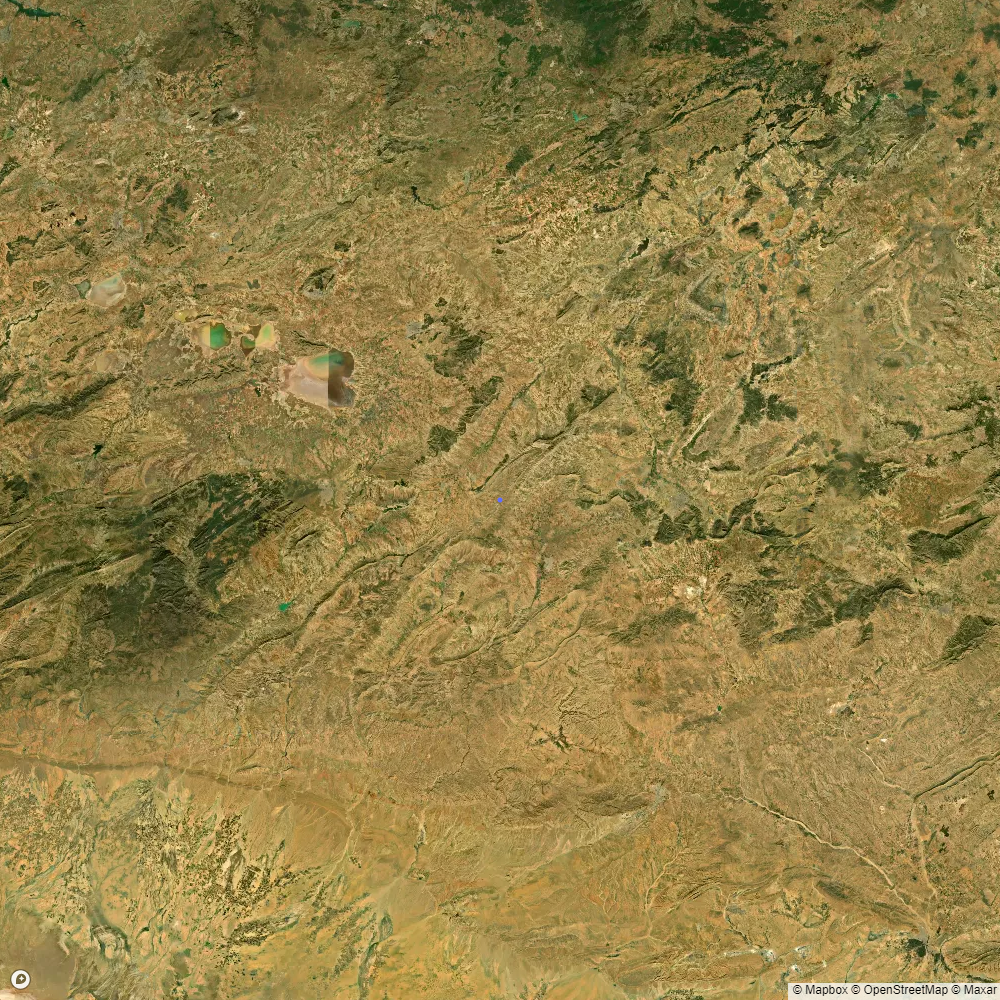

In [31]:
top_left_aoi, bottom_right_aoi = calculate_google_maps_bounding_box(lat, long, image_size, zoom_level)
print(f"Top Left Bounding box coordinates of the AOI image: {top_left_aoi}")
print(f"Bottom Right Bounding box coordinates of the AOI image: {bottom_right_aoi}")


# top_left_aoi, top_right_aoi, bottom_right_aoi, bottom_left_aoi = calculate_mapbox_bounding_box(lat, long, zoom_level, aoi_img.width, aoi_img.height)
# print(f"Bounding box coordinates of the AOI image:\n{top_left_aoi}, {top_right_aoi}\n{bottom_left_aoi}, {bottom_right_aoi}")

best_match, second_best_match = find_best_matches(correlation_map)
midpoint = find_midpoint(best_match, second_best_match)
print(f"\nMidpoint from correlation map: {midpoint}")

aoi_midpoint = scale_correlation_to_aoi(midpoint, correlation_map.shape, (aoi_img.width, aoi_img.height))
print(f"\nMidpoint in AOI image coordinates: {aoi_midpoint}")

geo_coords = interpolate_geo_coordinates(aoi_midpoint, top_left_aoi, bottom_right_aoi, (aoi_img.width, aoi_img.height))
print(f"\nInterpolated geographic coordinates: {geo_coords[0], geo_coords[1]}")


mapbox_access_token = input('Enter Mapbox Aceess Token: ')
satellite_view = fetch_map_image(geo_coords[0], geo_coords[1], 8, '1000x1000', mapbox_access_token)


print(f"\nSatellite view of the location:")
if satellite_view.mode != 'RGB':
    satellite_view = satellite_view.convert('RGB')
display(satellite_view)


In [ ]:
# # generate requirements.txt
# !pip freeze > requirements.txt